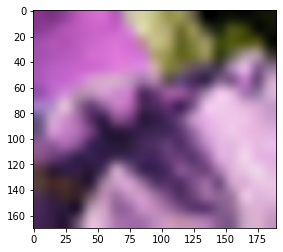

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
from PIL import *
from data import *
import math

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader as DL
import torch.nn.functional as F
import torch.nn.init as init
torch.cuda.empty_cache()

In [3]:
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


Using CUDA


In [4]:
# data_f = './'
# train_path = data_f + '\DIV2K_train_HR'
# test__path = data_f + 'Test/Set5/'

In [5]:
# train_set = DataSetF(train_path,2) ## input Image folder and scale
# test_set =  DataSetF(test__path,2)

In [6]:
# train_loader = DL(train_set,batch_size=40) ## input Image folder and scale
# test_loader =  DL(test_set,batch_size=30)

In [7]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(1,64,kernel_size = 9,padding = 4)
        self.conv_layer2 = nn.Conv2d(64,32,kernel_size = 1,padding = 0)
        self.conv_layer3 = nn.Conv2d(32,1,kernel_size = 5,padding = 2)
    
        
#     def forward_feed(self,x):
    def __call__(self,x):
        out = F.relu(self.conv_layer1(x))
        out = F.relu(self.conv_layer2(out))
        out = self.conv_layer3(out)
        return out

In [8]:
def Enhance_Image(model,image,scale,multichannel = False):
    device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
    converter = torch.load(model).to(device)
    img = Image.open(image)
    img = img.convert('YCbCr')
    img = myTransforms(scale).BicubicInterpolation(img)
    Y,Cb,Cr = img.split()
    tensor_img = transforms.ToTensor()
    channel1 = tensor_img(Y).view(1,-1,Y.size[1],Y.size[0]).to(device)
    out_channel1 = converter(channel1)
    out_channel1 = out_channel1.cpu()
    Y_enhanced =  np.array(out_channel1[0].detach())*255.
    Y_enhanced = Y_enhanced.clip(0,255)
    Y_enhanced = Image.fromarray(np.uint8(Y_enhanced[0]))
    res = Image.merge('YCbCr',[Y_enhanced,Cb,Cr]).convert('RGB')
    return res
    

In [9]:
def Train(model,number_of_epoch):
    lsv=[]
    psnrval=[]
    
    model = model.to(device)
    criterion = nn.MSELoss()
#     criterion = MS_SSIM_L1_LOSS()
    optimizer = optim.Adam(  # we use Adam instead of SGD like in the paper, because it's faster
    [
        {"params": model.conv_layer1.parameters(), "lr": 1e-4},  
        {"params": model.conv_layer2.parameters(), "lr": 1e-3},
        {"params": model.conv_layer3.parameters(), "lr": 1e-5},
    ], lr=1e-4,
    )
    for epoch in range(number_of_epoch):
        loss_in_epoch = 0
        for iteration,batch in enumerate(train_loader):
            img,label = batch[0].to(device),batch[1].to(device)
            
            optimizer.zero_grad()
            out_img = model(img)
#             print(label.shape,out_img.shape)
            loss = criterion(out_img,label)
            loss.backward()
            optimizer.step()
            loss_in_epoch += loss.item()
            
        print(f"Epoch {epoch}. Training loss: {loss_in_epoch/ len(train_loader)}")
        lsv += [loss_in_epoch/ len(train_loader)]
        psnrval += [Test_with_psnr(model)]
    torch.save(model,f"adam_model_{epoch}.pth")
    return lsv,psnrval

def Test_with_psnr(model):
    avg_psnr = 0
    for batch in test_loader:
        img,label = batch[0].to(device),batch[1].to(device)
        out = model(img)
        psnr = PSNR(out,label)
        avg_psnr += psnr
    print("Avg. PSNR :",{avg_psnr / len(test_loader)}, "dB.")
    return avg_psnr / len(test_loader)
    
def PSNR(imageTensor,labelTensor):
    criterion = nn.MSELoss()
    loss = criterion(imageTensor,labelTensor)
    psnr = 10*math.log10(1/loss.item())
    return psnr
def PSNR_img(image,label):
    assert image.size==label.size
    tensor = transforms.ToTensor()
    imageTensor = tensor(image)
    labelTensor = tensor(label)
    return PSNR(imageTensor,labelTensor)

In [10]:
# len(train_set)

801

In [66]:
# model = SRCNN()
# lsv,psnrval = Train(model,100)

Epoch 0. Training loss: 0.23144648000597953
Avg. PSNR : {10.369244904459798} dB.


KeyboardInterrupt: 

In [11]:
# plt.scatter(range(1000),lsv)
# plt.xlabel("Number of epochs")
# plt.ylabel("Loss Value ")
# plt.title("MSE variation using Adam Optimiser")
# plt.savefig("Variation of MSE")

NameError: name 'lsv' is not defined

In [12]:
# plt.style.use('seaborn')
# plt.plot(psnrval)
# plt.xlabel("Number of epochs")
# plt.ylabel("Avg. PSNR Value(in dB)")
# plt.savefig("Variation of PSNR")

NameError: name 'psnrval' is not defined

In [5]:
# model = 'adam_model_999.pth'
# image = 'FP.jpg'
# scl = 1

# low_res = myTransforms(scl).downscale(Image.open(image))
# low_res.save('Low_Res.bmp')
# interpolated_img = myTransforms(30).BicubicInterpolation(low_res)
# interpolated_img.save("Interpolated.bmp")
# device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


MemoryError: 

In [ ]:
# img = Enhance_Image(model,'Low_Res.bmp',2)
# img.save('Final_image.bmp')
# plt.imshow(img)